# 5장. 회원 탈퇴를 예측하는 테크닉(회원 이탈 예측)
4장에서 했던 클러스터링을 통한 행동 분석은 사용 방법에 따라 많은 가능성이 있는 기술임.  
행동 패턴을 분석할 수 있으면 어떤 고객이 탈퇴할지와 같은 예측도 가능 -> 탈퇴 방지를 위한 정책 준비 가능  

여기서는 탈퇴회원 및 지속회원 데이터를 바탕으로, 이 회원이 이탈할지를 예측하는 지도학습 모델링(분류-의사결정나무)를 해본다.  
의사결정나무는 아주 간단한 알고리즘이지만, 원인 분석이 쉽기 때문에 현장에서 자주 사용되는 알고리즘이다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Tech 41. 데이터를 읽어들이고 이용데이터를 수정하자.
- 여기선 3장에서 만든 customer_join, 4장에서 만든 use_log_months 데이터 2가지를 사용한다.

In [2]:
import pandas as pd
c = pd.read_csv('customer_join.csv')
ul_m = pd.read_csv('use_log_months.csv')

display(c, ul_m)

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,flag,cal_date,mem_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1,2019-04-30,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4187,HD676663,XXXX,C01,M,2019-03-14,NaN,CA1,0,0_종일,10500,2_일반,8.000000,8.0,8,8,0,2019-04-30,1
4188,HD246549,XXXXX,C01,F,2019-03-14,NaN,CA1,0,0_종일,10500,2_일반,10.000000,10.0,10,10,0,2019-04-30,1
4189,GD037007,XXXXX,C03,M,2019-03-14,NaN,CA1,0,2_야간,6000,2_일반,8.000000,8.0,8,8,0,2019-04-30,1
4190,OA953150,XXXXX,C01,M,2019-03-14,NaN,CA1,0,0_종일,10500,2_일반,11.000000,11.0,11,11,0,2019-04-30,1


,연월,customer_id,cnt
0,2018-04,AS002855,4
1,2018-04,AS009013,2
2,2018-04,AS009373,3
3,2018-04,AS015315,6
4,2018-04,AS015739,7
...,...,...,...
36837,2019-03,TS995853,8
36838,2019-03,TS998593,8
36839,2019-03,TS999079,3
36840,2019-03,TS999231,6


In [3]:
# 머신러닝 모델에 적용할 수 있는 데이터를 만들기 위해 데이터를 가공한다.
# 이번에는 미래를 예측하기 위해 그 달과 그 전 달의 데이터프레임을 만든다. (이전에 4장에선 그 달과, 그 달에 대응하는 6개월 전 데이터프레임을 만들었다.)
    ## 이번에 이렇게 하는 이유는 -> 6개월로 하면 가입 5개월 이내인 회원의 탈퇴는 예측할 수 없기 때문!
    # 3장에서도 봤지만 '마의 10개월'이라,, 10개월을 넘긴 회원이 많이 없고, 불과 몇개월 되지 않아 탈퇴한 회원도 있었다. 그래서 1개월 간격으로 줄인다.
    
## 이번 코드는 4장에서 가공한 데이터프레임과 비슷한데, 6개월-> 1개월로 단축하였으므로 이전에 만든 코드를 조금만 수정하자.
year_months = list(ul_m['연월'].unique())
uselog = pd.DataFrame() #비슷하게 빈 데이터프레임을 생성하고 여기에 가공한 데이터를 쌓아준다.
year_months

['2018-04',
 '2018-05',
 '2018-06',
 '2018-07',
 '2018-08',
 '2018-09',
 '2018-10',
 '2018-11',
 '2018-12',
 '2019-01',
 '2019-02',
 '2019-03']

In [4]:
ul_m.head()

,연월,customer_id,cnt
0,2018-04,AS002855,4
1,2018-04,AS009013,2
2,2018-04,AS009373,3
3,2018-04,AS015315,6
4,2018-04,AS015739,7


In [5]:
for i in range(1, len(year_months)): #직전 달의 데이터를 얻을 수 있어야 하므로 2018년 5월~2019년 3월까지에 대해서만 설정. 그래서 인덱스 1부터 시작
    
    #해당 월에 대한 임시 데이터프레임 생성
    tmp = ul_m.loc[ul_m['연월'] == year_months[i]]
    tmp.rename(columns = {'cnt': 'cnt_0'}, inplace=True)
    
    #그리고 해당 월의 바로 직전 달에 대한 임시 데이터프레임 생성
    tmp_before = ul_m.loc[ul_m['연월'] == year_months[i-1]]
    del tmp_before['연월'] #'연월' 컬럼은 2번 쓸 필요 없으므로 삭제
    tmp_before.rename(columns = {'cnt': 'cnt_1'}, inplace=True)
    
    #이제 두 데이터프레임을 결합
    tmp = pd.merge(tmp, tmp_before, on = 'customer_id', how='left')
    
    #tmp를 빈 데이터프레임인 uselog에 차곡차곡 쌓기(row-bind)
    uselog = pd.concat([uselog, tmp], axis=0, ignore_index=True) #행 인덱스를 그대로 붙이지 않고 초기화시킴
    
uselog

,연월,customer_id,cnt_0,cnt_1
0,2018-05,AS002855,5,4.0
1,2018-05,AS009373,4,3.0
2,2018-05,AS015233,7,NaN
3,2018-05,AS015315,3,6.0
4,2018-05,AS015739,5,7.0
...,...,...,...,...
33846,2019-03,TS995853,8,11.0
33847,2019-03,TS998593,8,7.0
33848,2019-03,TS999079,3,2.0
33849,2019-03,TS999231,6,6.0


이렇게 머신러닝을 적용할 새로운 데이터프레임 'uselog'가 만들어졌다.  
해당 연월의 이용횟수는 cnt_0에, 해당월 바로 전 월의 이용횟수는 cnt_1에 담긴다.  

---
각 회원의 해당 월 및 바로 전 월의 이용횟수 데이터를 만들어보았다. 이제 예측을 위해 가장 중요한 컬럼을 생성해보자.  
바로 **이 회원이 탈퇴했는가 or 아닌가** 의 컬럼이다.  
이를 위해선 `is_deleted` 열을 통해 해당회원이 탈퇴회원인지, 지속회원인지를 알 수 있다. -> tech 42, 43에서 알아보자.

## Tech 42. 탈퇴 전월의 탈퇴 고객 데이터를 작성하자.
이 헬스장은 특이하게도 탈퇴를 하고 싶으면 그 전 달에 탈퇴신청을 해야만 한다.  
예를 들어, 2019년 2월에 탈퇴하고 싶어 탈퇴신청을 하면 2019년 3월에 탈퇴처리가 완료되는 식이다.  
그래서 이 데이터 분석에서는 탈퇴시점(end_date)뿐 아니라 탈퇴 전 시점(탈퇴시점의 1달 전)이 중요하다. end_date는 데이터로 주어져 있지만, 탈퇴 전 시점은 없으므로 `exit_date` 라는 새로운 컬럼을 만들어보자.   

---
-> 이 과정을 통해 우리는 *탈퇴한 회원이 그만두기 전월의 상태를 나타내는 데이터*를 만들 수 있다.

In [6]:
from dateutil.relativedelta import relativedelta

#우선 탈퇴고객을 뽑는다. (1350명)
exit_c = c.loc[c['is_deleted'] == 1]
#탈퇴 전 시점인 'exit_date'를 만들고, 탈퇴시점 'end_date'는 datetime으로 바꿔준다.
exit_c['exit_date'] = None
exit_c['end_date'] = pd.to_datetime(exit_c['end_date'])
exit_c

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,flag,cal_date,mem_period,exit_date
708,TS511179,XXXXXX,C01,F,2016-05-01,2018-04-30,CA1,1,0_종일,10500,2_일반,3.0,3.0,3,3,0,2018-04-30,23,None
729,TS443736,XXXX,C02,M,2016-05-01,2018-04-30,CA1,1,1_주간,7500,2_일반,3.0,3.0,3,3,0,2018-04-30,23,None
730,HD542886,XX,C01,M,2016-05-01,2018-04-30,CA1,1,0_종일,10500,2_일반,1.0,1.0,1,1,0,2018-04-30,23,None
770,HD597545,XXXXX,C03,F,2016-06-01,2018-05-31,CA1,1,2_야간,6000,2_일반,3.5,3.5,4,3,1,2018-05-31,23,None
785,HI749296,XXXXX,C01,M,2016-06-01,2018-05-31,CA1,1,0_종일,10500,2_일반,3.0,3.0,3,3,0,2018-05-31,23,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4049,OA143589,XXXXX,C03,F,2019-01-15,2019-02-28,CA1,1,2_야간,6000,2_일반,4.5,4.5,6,3,0,2019-02-28,1,None
4050,GD367382,XXXX,C01,M,2019-01-15,2019-03-31,CA1,1,0_종일,10500,2_일반,7.0,6.0,12,3,0,2019-03-31,2,None
4068,OA034442,XXXXX,C02,M,2019-02-05,2019-03-31,CA1,1,1_주간,7500,2_일반,7.0,7.0,11,3,0,2019-03-31,1,None
4086,PL508278,XXXXX,C03,M,2019-02-09,2019-03-31,CA1,1,2_야간,6000,2_일반,7.0,7.0,10,4,0,2019-03-31,1,None


In [7]:
exit_c.dtypes

customer_id              object
name                     object
class                    object
gender                   object
start_date               object
end_date         datetime64[ns]
campaign_id              object
is_deleted                int64
class_name               object
price                     int64
campaign_name            object
mean                    float64
median                  float64
max                       int64
min                       int64
flag                      int64
cal_date                 object
mem_period                int64
exit_date                object
dtype: object

In [8]:
#이제 exit_date 컬럼을 end_date에서 1개월 전의 날짜로 채워보자.
for i in range(len(exit_c)):
    exit_c['exit_date'].iloc[i] = (exit_c['end_date'].iloc[i] - relativedelta(months = 1))
exit_c.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,flag,cal_date,mem_period,exit_date
708,TS511179,XXXXXX,C01,F,2016-05-01,2018-04-30,CA1,1,0_종일,10500,2_일반,3.0,3.0,3,3,0,2018-04-30,23,2018-03-30 00:00:00
729,TS443736,XXXX,C02,M,2016-05-01,2018-04-30,CA1,1,1_주간,7500,2_일반,3.0,3.0,3,3,0,2018-04-30,23,2018-03-30 00:00:00
730,HD542886,XX,C01,M,2016-05-01,2018-04-30,CA1,1,0_종일,10500,2_일반,1.0,1.0,1,1,0,2018-04-30,23,2018-03-30 00:00:00
770,HD597545,XXXXX,C03,F,2016-06-01,2018-05-31,CA1,1,2_야간,6000,2_일반,3.5,3.5,4,3,1,2018-05-31,23,2018-04-30 00:00:00
785,HI749296,XXXXX,C01,M,2016-06-01,2018-05-31,CA1,1,0_종일,10500,2_일반,3.0,3.0,3,3,0,2018-05-31,23,2018-04-30 00:00:00


In [9]:
exit_c.dtypes

customer_id              object
name                     object
class                    object
gender                   object
start_date               object
end_date         datetime64[ns]
campaign_id              object
is_deleted                int64
class_name               object
price                     int64
campaign_name            object
mean                    float64
median                  float64
max                       int64
min                       int64
flag                      int64
cal_date                 object
mem_period                int64
exit_date                object
dtype: object

In [10]:
#exit_c 데이터프레임에  exit_date에서 뽑은 '연월' 컬럼을 추가해보자. (신기,, object인데도 되는군..? -> 에러였나봄 안됨.)
exit_c['exit_date'] = pd.to_datetime(exit_c['exit_date'])
exit_c['연월'] = exit_c['exit_date'].dt.strftime("%Y-%m")
exit_c.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,flag,cal_date,mem_period,exit_date,연월
708,TS511179,XXXXXX,C01,F,2016-05-01,2018-04-30,CA1,1,0_종일,10500,2_일반,3.0,3.0,3,3,0,2018-04-30,23,2018-03-30,2018-03
729,TS443736,XXXX,C02,M,2016-05-01,2018-04-30,CA1,1,1_주간,7500,2_일반,3.0,3.0,3,3,0,2018-04-30,23,2018-03-30,2018-03
730,HD542886,XX,C01,M,2016-05-01,2018-04-30,CA1,1,0_종일,10500,2_일반,1.0,1.0,1,1,0,2018-04-30,23,2018-03-30,2018-03
770,HD597545,XXXXX,C03,F,2016-06-01,2018-05-31,CA1,1,2_야간,6000,2_일반,3.5,3.5,4,3,1,2018-05-31,23,2018-04-30,2018-04
785,HI749296,XXXXX,C01,M,2016-06-01,2018-05-31,CA1,1,0_종일,10500,2_일반,3.0,3.0,3,3,0,2018-05-31,23,2018-04-30,2018-04


In [11]:
#탈퇴회원의 이용이력이 어떻게 되는지를 알기 위해서, 앞서 가공한 uselog 데이터셋의 '연월' 컬럼과 조인시키자. 
uselog.dtypes

연월              object
customer_id     object
cnt_0            int64
cnt_1          float64
dtype: object

In [12]:
#uselog를 기준으로 left join 시켰으므로 uselog의 행개수와 같아진다. 
## 결과를 보면 NaN값이 매우 많은데, uselog의 customer가 탈퇴회원이 아닌 경우 NaN으로 나온다. -> 이런 결측치는 삭제해주자.
exit_uselog = pd.merge(uselog, exit_c, on = ['customer_id', '연월'], how='left')
print(len(uselog))
print(len(exit_uselog))
exit_uselog.head()

33851
33851


,연월,customer_id,cnt_0,cnt_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,flag,cal_date,mem_period,exit_date
0,2018-05,AS002855,5,4.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,2018-05,AS009373,4,3.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,2018-05,AS015233,7,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,2018-05,AS015315,3,6.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,2018-05,AS015739,5,7.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [13]:
#exit_uselog에서 'name'에 결측치가 하나라도 있으면 삭제 -> 1104개 데이터로 줄어듦 
exit_uselog = exit_uselog.dropna(subset = ['name'])
print(len(exit_uselog))
print(exit_uselog['customer_id'].nunique())
exit_uselog.head()

1104
1104


,연월,customer_id,cnt_0,cnt_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,flag,cal_date,mem_period,exit_date
19,2018-05,AS055680,3,3.0,XXXXX,C01,M,2018-03-01,2018-06-30,CA1,...,10500.0,2_일반,3.000000,3.0,3.0,3.0,0.0,2018-06-30,3.0,2018-05-30
57,2018-05,AS169823,2,3.0,XX,C01,M,2017-11-01,2018-06-30,CA1,...,10500.0,2_일반,3.000000,3.0,4.0,2.0,1.0,2018-06-30,7.0,2018-05-30
110,2018-05,AS305860,5,3.0,XXXX,C01,M,2017-06-01,2018-06-30,CA1,...,10500.0,2_일반,3.333333,3.0,5.0,2.0,0.0,2018-06-30,12.0,2018-05-30
128,2018-05,AS363699,5,3.0,XXXXX,C01,M,2018-02-01,2018-06-30,CA1,...,10500.0,2_일반,3.333333,3.0,5.0,2.0,0.0,2018-06-30,4.0,2018-05-30
147,2018-05,AS417696,1,4.0,XX,C03,F,2017-09-01,2018-06-30,CA1,...,6000.0,2_일반,2.000000,1.0,4.0,1.0,0.0,2018-06-30,9.0,2018-05-30


In [14]:
exit_uselog.isna().sum()

연월                0
customer_id       0
cnt_0             0
cnt_1            52
name              0
class             0
gender            0
start_date        0
end_date          0
campaign_id       0
is_deleted        0
class_name        0
price             0
campaign_name     0
mean              0
median            0
max               0
min               0
flag              0
cal_date          0
mem_period        0
exit_date         0
dtype: int64

이로써 우리는 **특정 회원이 탈퇴하기 전월의 상태를 나타내는 데이터** 인 `exit_uselog` 데이터를 만들어보았다.  
이 데이터는 모두 탈퇴를 한 회원의 데이터이며, cnt_1 에만 52개의 결측치가 있는데, 탈퇴 2개월 전 월에 사용한 적이 없는 경우이다 -> 추후 결측치를 처리하자.  
이번에는 탈퇴를 하지 않은, 지속회원은 어떤 상태를 보이는지를 분석해보자.

## Tech 43. 지속회원의 데이터를 작성하자
지속회원은 탈퇴를 한 적이 없기 때문에 어떤 연월의 데이터를 작성해도 상관없다.

In [15]:
#지속회원 추출
conti_c = c[c['is_deleted'] == 0]
print(len(conti_c))

#uselog 데이터와 결합
conti_uselog = pd.merge(uselog, conti_c, on = ['customer_id'], how='left')
print(len(conti_uselog))
conti_uselog

2842
33851


,연월,customer_id,cnt_0,cnt_1,name,class,gender,start_date,end_date,campaign_id,...,class_name,price,campaign_name,mean,median,max,min,flag,cal_date,mem_period
0,2018-05,AS002855,5,4.0,XXXX,C03,F,2016-11-01,NaN,CA1,...,2_야간,6000.0,2_일반,4.500000,5.0,7.0,2.0,1.0,2019-04-30,29.0
1,2018-05,AS009373,4,3.0,XX,C01,F,2015-11-01,NaN,CA1,...,0_종일,10500.0,2_일반,5.083333,5.0,7.0,3.0,1.0,2019-04-30,41.0
2,2018-05,AS015233,7,NaN,XXXXX,C01,M,2018-05-13,NaN,CA2,...,0_종일,10500.0,0_입회비반액할인,7.545455,7.0,11.0,4.0,1.0,2019-04-30,11.0
3,2018-05,AS015315,3,6.0,XXXXX,C01,M,2015-07-01,NaN,CA1,...,0_종일,10500.0,2_일반,4.833333,5.0,7.0,3.0,1.0,2019-04-30,45.0
4,2018-05,AS015739,5,7.0,XXXXX,C03,M,2017-06-01,NaN,CA1,...,2_야간,6000.0,2_일반,5.583333,5.5,8.0,4.0,1.0,2019-04-30,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33846,2019-03,TS995853,8,11.0,XXXX,C01,M,2019-02-08,NaN,CA1,...,0_종일,10500.0,2_일반,9.500000,9.5,11.0,8.0,1.0,2019-04-30,2.0
33847,2019-03,TS998593,8,7.0,XXXXX,C03,M,2018-09-01,NaN,CA1,...,2_야간,6000.0,2_일반,8.142857,8.0,9.0,7.0,1.0,2019-04-30,7.0
33848,2019-03,TS999079,3,2.0,XXX,C03,M,2016-06-01,NaN,CA1,...,2_야간,6000.0,2_일반,4.916667,5.5,9.0,2.0,1.0,2019-04-30,34.0
33849,2019-03,TS999231,6,6.0,XXXX,C01,M,2017-03-01,NaN,CA1,...,0_종일,10500.0,2_일반,4.666667,5.0,8.0,1.0,1.0,2019-04-30,25.0


지속회원은 2842명이며, 조인 후 결측치가 있으므로 아까와 마찬가지로 'name'에 결측치가 있으면 drop한다.

In [16]:
conti_uselog.isna().sum()

연월                   0
customer_id          0
cnt_0                0
cnt_1             1201
name              6429
class             6429
gender            6429
start_date        6429
end_date         33851
campaign_id       6429
is_deleted        6429
class_name        6429
price             6429
campaign_name     6429
mean              6429
median            6429
max               6429
min               6429
flag              6429
cal_date          6429
mem_period        6429
dtype: int64

In [17]:
conti_uselog = conti_uselog.dropna(subset = ['name'])
print(len(conti_uselog))
print( )
print(conti_uselog.isna().sum())

27422

연월                   0
customer_id          0
cnt_0                0
cnt_1              688
name                 0
class                0
gender               0
start_date           0
end_date         27422
campaign_id          0
is_deleted           0
class_name           0
price                0
campaign_name        0
mean                 0
median               0
max                  0
min                  0
flag                 0
cal_date             0
mem_period           0
dtype: int64


지속회원의 이용이력 데이터인 `conti_uselog` 또한 직전 달에 688개의 결측치가 존재한다.

- `exit_uselog` : 총 1104개
- `conti_uselog` : 총 27422개
- 이러한 결과가 나타나는 이유는 uselog를 기준으로 left join 시켰기 때문이다.
    - 특히 지속회원의 경우엔 탈퇴를 한 적이 없으므로 동일인에 대해 여러 개의 행이 존재할 수 있다.
    - 이를테면 Everly라는 사람이 2018년 10월과 2019년 1월 두번 다 이용이력이 있다면 2개의 행으로 존재한다.
- 하지만 이렇게 되면 지속회원에 비해 탈퇴회원의 데이터가 매우 적게 되어버린다.(불균형 데이터: imbalanced data) ex) 신용카드 부정 감지처럼,, 그럼 좋은 예측 성능을 기대하기 어려움
    - 이를 위해 지속회원 데이터가 회원당 여러개가 아닌 딱 1개의 데이터만 남을 수 있도록 언더샘플링한다. 
    - 데이터를 섞고 동일인에 대해선 중복을 제거하여 1명당 1개 행만 남도록 해보자.

In [18]:
#데이터 섞고 중복 제거 (고객별로 랜덤하게 단 하나)
conti_uselog = conti_uselog.sample(frac = 1, random_state = 99).reset_index(drop = True) #frac은 뽑는 비율을 의미, 0~1 사이값을 설정 가능. 인덱스가 랜덤히 섞이므로 인덱스도 리셋해줘야 함
                                                                                                                                    ## 참고로 여기서 인덱스가 랜덤히 섞이기 때문에 실행할 때마다 다른 결과가 나옴 -> 추후 모델링 성능에 영향 미칠수도 있음
conti_uselog = conti_uselog.drop_duplicates(subset = 'customer_id') #고객id의 중복 제거, 디폴트로는 첫번째 값만 남기고 나머지는 drop
print(len(conti_uselog))
conti_uselog.head()

2842


,연월,customer_id,cnt_0,cnt_1,name,class,gender,start_date,end_date,campaign_id,...,class_name,price,campaign_name,mean,median,max,min,flag,cal_date,mem_period
0,2018-06,PL399207,5,5.0,XXXX,C02,M,2016-06-01,NaN,CA1,...,1_주간,7500.0,2_일반,4.666667,5.0,7.0,2.0,1.0,2019-04-30,34.0
1,2018-06,HI305974,1,6.0,XXXXX,C01,M,2016-09-01,NaN,CA1,...,0_종일,10500.0,2_일반,5.166667,5.5,7.0,1.0,1.0,2019-04-30,31.0
2,2019-03,TS294433,3,5.0,XXX,C01,F,2017-06-01,NaN,CA1,...,0_종일,10500.0,2_일반,5.833333,6.0,10.0,2.0,1.0,2019-04-30,22.0
3,2019-03,OA061841,3,5.0,XXXX,C01,M,2016-12-01,NaN,CA1,...,0_종일,10500.0,2_일반,5.083333,5.0,10.0,2.0,1.0,2019-04-30,28.0
4,2018-12,TS002058,1,4.0,XXXXXX,C01,F,2016-11-01,NaN,CA1,...,0_종일,10500.0,2_일반,4.750000,5.5,7.0,1.0,1.0,2019-04-30,29.0


In [19]:
#이렇게 탈퇴회원과 지속회원 데이터 개수를 비슷하게 맞췄다. 이 둘을 row-bind로 묶고 새로운 데이터셋 'pred_data'를 만들어보자
pred_data = pd.concat([conti_uselog, exit_uselog], ignore_index = True)
pred_data

,연월,customer_id,cnt_0,cnt_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,flag,cal_date,mem_period,exit_date
0,2018-06,PL399207,5,5.0,XXXX,C02,M,2016-06-01,NaN,CA1,...,7500.0,2_일반,4.666667,5.0,7.0,2.0,1.0,2019-04-30,34.0,NaT
1,2018-06,HI305974,1,6.0,XXXXX,C01,M,2016-09-01,NaN,CA1,...,10500.0,2_일반,5.166667,5.5,7.0,1.0,1.0,2019-04-30,31.0,NaT
2,2019-03,TS294433,3,5.0,XXX,C01,F,2017-06-01,NaN,CA1,...,10500.0,2_일반,5.833333,6.0,10.0,2.0,1.0,2019-04-30,22.0,NaT
3,2019-03,OA061841,3,5.0,XXXX,C01,M,2016-12-01,NaN,CA1,...,10500.0,2_일반,5.083333,5.0,10.0,2.0,1.0,2019-04-30,28.0,NaT
4,2018-12,TS002058,1,4.0,XXXXXX,C01,F,2016-11-01,NaN,CA1,...,10500.0,2_일반,4.750000,5.5,7.0,1.0,1.0,2019-04-30,29.0,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3941,2019-02,TS645212,4,2.0,XXXX,C03,F,2018-03-01,2019-03-31 00:00:00,CA1,...,6000.0,2_일반,4.500000,4.5,7.0,1.0,0.0,2019-03-31,12.0,2019-02-28
3942,2019-02,TS741703,5,6.0,XXXX,C03,M,2018-12-08,2019-03-31 00:00:00,CA3,...,6000.0,1_입회비무료,6.250000,6.0,8.0,5.0,0.0,2019-03-31,3.0,2019-02-28
3943,2019-02,TS859258,1,3.0,XXXXX,C02,F,2018-12-07,2019-03-31 00:00:00,CA3,...,7500.0,1_입회비무료,2.500000,2.0,5.0,1.0,0.0,2019-03-31,3.0,2019-02-28
3944,2019-02,TS886985,5,3.0,XXX,C02,F,2018-03-01,2019-03-31 00:00:00,CA1,...,7500.0,2_일반,4.250000,4.0,7.0,2.0,1.0,2019-03-31,12.0,2019-02-28


## Tech 44. 예측할 달의 재적 기간을 작성하자
위의 pred_data에 새로운 변수를 추가해보자. 여기서는 '재적 기간'이라는 시계열 변수를 추가한다. (어차피 이용횟수도 해당 달, 전 달의 횟수이므로 시계열 변수)  
재적기간(period) 변수는 4장에서 한 것과 마찬가지로 현재연월에서 가입시기(start_date) 값을 빼면 된다.

In [20]:
pred_data['period'] = 0 #초기화
pred_data['now_date'] = pd.to_datetime(pred_data['연월'], format = '%Y-%m-%d')
pred_data['start_date'] = pd.to_datetime(pred_data['start_date'])

#두 기간의 차이 계산(단위: month)
for i in range(len(pred_data)):
    delta = relativedelta(pred_data['now_date'][i], pred_data['start_date'][i])
    pred_data.loc[i, 'period'] = delta.years*12 + delta.months
    
pred_data.head()

,연월,customer_id,cnt_0,cnt_1,name,class,gender,start_date,end_date,campaign_id,...,mean,median,max,min,flag,cal_date,mem_period,exit_date,period,now_date
0,2018-06,PL399207,5,5.0,XXXX,C02,M,2016-06-01,NaN,CA1,...,4.666667,5.0,7.0,2.0,1.0,2019-04-30,34.0,NaT,24,2018-06-01
1,2018-06,HI305974,1,6.0,XXXXX,C01,M,2016-09-01,NaN,CA1,...,5.166667,5.5,7.0,1.0,1.0,2019-04-30,31.0,NaT,21,2018-06-01
2,2019-03,TS294433,3,5.0,XXX,C01,F,2017-06-01,NaN,CA1,...,5.833333,6.0,10.0,2.0,1.0,2019-04-30,22.0,NaT,21,2019-03-01
3,2019-03,OA061841,3,5.0,XXXX,C01,M,2016-12-01,NaN,CA1,...,5.083333,5.0,10.0,2.0,1.0,2019-04-30,28.0,NaT,27,2019-03-01
4,2018-12,TS002058,1,4.0,XXXXXX,C01,F,2016-11-01,NaN,CA1,...,4.750000,5.5,7.0,1.0,1.0,2019-04-30,29.0,NaT,25,2018-12-01


## Tech 45. 결측치 처리
이제 pred_data가 거의 완성되었다. 남은 것은 NaN(결측치)! NaN이 있는 데이터로는 머신러닝이 불가능하기 때문에 이를 처리하는 것은 중요함.

In [21]:
#결측치 파악
pred_data.isna().sum()

연월                  0
customer_id         0
cnt_0               0
cnt_1             252
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
mean                0
median              0
max                 0
min                 0
flag                0
cal_date            0
mem_period          0
exit_date        2842
period              0
now_date            0
dtype: int64

end_date와 exit_date에 2842개의 결측치는 지속회원이기 때문이다. (이 변수들은 결측치가 있는 게 당연)  
그러니 cnt_1 변수에 대해서만 결측치를 처리해준다. cnt_1 (이전 달의 이용횟수)가 없으면 그냥 그 행 전체를 drop하자.

In [22]:
pred_data = pred_data.dropna(subset = ['cnt_1'])
pred_data.isnull().sum()

연월                  0
customer_id         0
cnt_0               0
cnt_1               0
name                0
class               0
gender              0
start_date          0
end_date         2642
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
mean                0
median              0
max                 0
min                 0
flag                0
cal_date            0
mem_period          0
exit_date        2642
period              0
now_date            0
dtype: int64

## Tech 46. 문자열 변수 처리 
앞에서 NaN은 제거했지만, 하나가 더 남았다. 바로 문자열 변수!  
가입 캠페인 구분, 회원 구분, 성별 등의 문자열 변수도 머신러닝에 사용하기 위해서는 적절한 가공을 해줘야 하며(문자는 머신러닝 모델이 인식하지 못하기 때문),  
이런 문자열 변수를 `카테고리 변수` 라고 한다.  
카테고리 변수를 숫자처럼 인식 가능하게 해주기 위해서는 **더미 변수화** 를 한다. 문자열을 0과 1의 값을 가진 숫자로 바꿔주는 것이다.

In [23]:
pred_data.head()

,연월,customer_id,cnt_0,cnt_1,name,class,gender,start_date,end_date,campaign_id,...,mean,median,max,min,flag,cal_date,mem_period,exit_date,period,now_date
0,2018-06,PL399207,5,5.0,XXXX,C02,M,2016-06-01,NaN,CA1,...,4.666667,5.0,7.0,2.0,1.0,2019-04-30,34.0,NaT,24,2018-06-01
1,2018-06,HI305974,1,6.0,XXXXX,C01,M,2016-09-01,NaN,CA1,...,5.166667,5.5,7.0,1.0,1.0,2019-04-30,31.0,NaT,21,2018-06-01
2,2019-03,TS294433,3,5.0,XXX,C01,F,2017-06-01,NaN,CA1,...,5.833333,6.0,10.0,2.0,1.0,2019-04-30,22.0,NaT,21,2019-03-01
3,2019-03,OA061841,3,5.0,XXXX,C01,M,2016-12-01,NaN,CA1,...,5.083333,5.0,10.0,2.0,1.0,2019-04-30,28.0,NaT,27,2019-03-01
4,2018-12,TS002058,1,4.0,XXXXXX,C01,F,2016-11-01,NaN,CA1,...,4.750000,5.5,7.0,1.0,1.0,2019-04-30,29.0,NaT,25,2018-12-01


변수가 너무 많은데, 여기서 우리가 모델링에 사용할 변수는 다음과 같다.

- 설명변수(X) : cnt_1, campaign_name, class_name, gender, flag, period
- 종속변수(target): is_deleted

그 이유는 우리가 예측하려고 하는 것은 '이 사람이 탈퇴를 할 것인지 아닐 것인지' 이기 때문이다. 만일 is_deleted = 1로 예측되면 탈퇴가능성이 높고, 0이면 낮은 것이다.

In [24]:
#위의 변수만 따로 뽑아보자.
cols = ['cnt_1', 'campaign_name', 'class_name', 'gender', 'flag', 'period', 'is_deleted']
pred_data = pred_data[cols]
pred_data.head()

,cnt_1,campaign_name,class_name,gender,flag,period,is_deleted
0,5.0,2_일반,1_주간,M,1.0,24,0.0
1,6.0,2_일반,0_종일,M,1.0,21,0.0
2,5.0,2_일반,0_종일,F,1.0,21,0.0
3,5.0,2_일반,0_종일,M,1.0,27,0.0
4,4.0,2_일반,0_종일,F,1.0,25,0.0


In [25]:
#여기서 campaign_name과 class_name의 경우 너무 이름이 길기 때문에 숫자 뒤의 문자만 따로 뽑아보자.
print(pred_data.iloc[:, 1].unique())
print(pred_data.iloc[:, 2].unique())

['2_일반' '1_입회비무료' '0_입회비반액할인']
['1_주간' '0_종일' '2_야간']


In [26]:
pred_data.iloc[:,1] = pred_data.iloc[:, 1].str[2:]
pred_data.iloc[:,2] = pred_data.iloc[:, 2].str[2:]
pred_data.head()

,cnt_1,campaign_name,class_name,gender,flag,period,is_deleted
0,5.0,일반,주간,M,1.0,24,0.0
1,6.0,일반,종일,M,1.0,21,0.0
2,5.0,일반,종일,F,1.0,21,0.0
3,5.0,일반,종일,M,1.0,27,0.0
4,4.0,일반,종일,F,1.0,25,0.0


In [27]:
#잘 되었는지 다시 확인 -> 잘 되었다!
print(pred_data.iloc[:, 1].unique())
print(pred_data.iloc[:, 2].unique())

['일반' '입회비무료' '입회비반액할인']
['주간' '종일' '야간']


In [28]:
#이제 이 카테고리 변수들을 더미변수화한다. 해당하는 값이먄 1, 아니면 0의 값을 갖는 변수로 쪼개짐.
pred_data = pd.get_dummies(pred_data)
pred_data.head()

,cnt_1,flag,period,is_deleted,campaign_name_일반,campaign_name_입회비무료,campaign_name_입회비반액할인,class_name_야간,class_name_종일,class_name_주간,gender_F,gender_M
0,5.0,1.0,24,0.0,1,0,0,0,0,1,0,1
1,6.0,1.0,21,0.0,1,0,0,0,1,0,0,1
2,5.0,1.0,21,0.0,1,0,0,0,1,0,1,0
3,5.0,1.0,27,0.0,1,0,0,0,1,0,0,1
4,4.0,1.0,25,0.0,1,0,0,0,1,0,1,0


In [29]:
#하지만 주의점이 있다!
#만일 gender_F가 1이고 gender_M이 0이면? -> 여성이란 뜻이다.
#그렇다면 그냥 gender_F 변수만 남기고, 이 변수값이 1이면 여성, 0이면 남성임을 알 수 있다. 
    ## 그러므로, 만들어진 더미변수들은 하나씩 지워준다. (카테고리 개수가 n이면 더미변수는 n-1개만 필요함)

#여기선 내가 임의로 삭제했음
del pred_data['campaign_name_일반']
del pred_data['class_name_야간']
del pred_data['gender_M']

pred_data.head()

,cnt_1,flag,period,is_deleted,campaign_name_입회비무료,campaign_name_입회비반액할인,class_name_종일,class_name_주간,gender_F
0,5.0,1.0,24,0.0,0,0,0,1,0
1,6.0,1.0,21,0.0,0,0,1,0,0
2,5.0,1.0,21,0.0,0,0,1,0,1
3,5.0,1.0,27,0.0,0,0,1,0,0
4,4.0,1.0,25,0.0,0,0,1,0,1


## Tech 47. 의사결정나무를 활용해 탈퇴 예측 모델을 구축하자
드디어! 전처리가 끝나고 모델링을 할 준비가 되었다.

In [30]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.model_selection 

exit = pred_data[pred_data['is_deleted']== 1] #탈퇴회원
conti = pred_data[pred_data['is_deleted']==0].sample(len(exit)) #지속회원-> 랜덤하게 탈퇴회원 개수만큼 뽑음

#설명, 종속 변수 설정
X = pd.concat([exit, conti], ignore_index = True) #인덱스 초기화
y = X['is_deleted']
del X['is_deleted']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

In [31]:
print(len(X_train), len(X_test)) #학습셋은 1578개, 검증셋 526개로 쪼개짐 

1578 526


In [32]:
#모델 구축
model = DecisionTreeClassifier(random_state = 0)
model.fit(X_train, y_train)
#예측값
y_pred = model.predict(X_test)
print(y_pred)

[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0.
 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0.
 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1.
 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0.
 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.
 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0.

In [33]:
#예측된 값인 y_pred와 정답 데이터 y_test를 비교해 정확도 계산 (얼마나 맞췄을까?)

#두개를 갖고 데이터프레임 생성
result = pd.DataFrame({'actual': y_test, 'pred': y_pred})
result.head()

,actual,pred
534,1.0,1.0
526,1.0,1.0
429,1.0,1.0
306,1.0,1.0
1945,0.0,0.0


## Tech 48. 예측 모델을 평가하고, 모델을 튜닝하자
위에서 만든 result 데이터프레임을 바탕으로 정확도를 계산해 모델을 평가해보자.

In [34]:
#정확도는 actual과 pred가 일치하는 개수가 전체 개수 대비 얼마인지 비율을 계산하면 된다.

#둘이 일치하는 개수 (465개)
print(len(result[result['actual'] == result['pred']]))
print(len(result))

469
526


In [35]:
#그렇다면 일치 비율(정확도)은? -> 88%로 나쁘지 않다! (하지만 test data에 대해 계산하면 어떻게 될지 모른다)
print((len(result[result['actual'] == result['pred']])/len(result))*100)

89.16349809885932


In [36]:
#이번엔 함수 score를 사용해 정확도 계산
print(model.score(X_train, y_train))
print(model.score(X_test, y_test)) 

0.9778200253485425
0.8916349809885932


와우 train data에 대해 정확도를 계산하면 무려 98%로 엄청난 과적합이 발생한다.  
이를 검증셋에 대해 검정하면 88%의 정확도밖에 안되는데..!  

---
이러한 경우, *데이터를 늘리거나, 변수를 재검토, 모델의 파라미터 변경* 등의 방법을 활용해 과적합을 없앤 이상적인 모델을 만들 수 있다.  
여기서는 모델의 파라미터를 변경해서 모델을 수정해보자.

In [37]:
#의사결정나무는 과적합을 방지하기 위해 트리 깊이를 얕게 하면 모델을 단순화할 수 있다.

#설명, 종속 변수 설정
X = pd.concat([exit, conti], ignore_index = True) #인덱스 초기화
y = X['is_deleted']
del X['is_deleted']

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

#모델 구축
model = DecisionTreeClassifier(random_state = 0, max_depth = 5) #파라미터 변경
model.fit(X_train, y_train)
#예측값
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.9296577946768061
0.903041825095057


트리 깊이를 5까지만 제한하였더니, train data에 대한 정확도는 92%로 낮아졌으나 검증셋에 대해선 약 92%로 정확도가 높아졌다.  
즉 과적합을 잘 방지한 것으로 볼 수 있다. 

## Tech 49.  모델에 기여하는 변수를 확인하자

In [38]:
imp = pd.DataFrame({'feature': X.columns, 'coefficient': model.feature_importances_})
imp = imp.sort_values(by = 'coefficient', ascending= False)
imp

,feature,coefficient
2,period,0.527370
0,cnt_1,0.351241
1,flag,0.120352
6,class_name_주간,0.000654
7,gender_F,0.000383
3,campaign_name_입회비무료,0.000000
4,campaign_name_입회비반액할인,0.000000
5,class_name_종일,0.000000


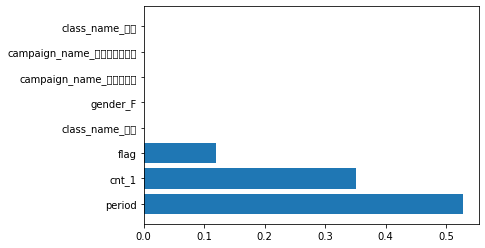

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.barh(imp['feature'], imp['coefficient'])
plt.show()

가장 영향력이 큰 변수는 period(재적기간) > cnt_1(바로 직전 달의 이용횟수) > flag(정기적 이용 여부) 로 나타났으며, 나머지 카테고리 변수는 거의 0에 가까운 미미한 영향력을 나타냈다.

## Tech 50. 회원 탈퇴를 예측하자
마지막으로는 직접 예제 데이터를 바탕으로 이 회원이 탈퇴할지 아닐지를 예측해본다.

In [40]:
#책의 예제 데이터 (임의 설정)
cnt_1 = 3
flag = 1
period = 10
campaign_name = '입회비무료'
class_name = '종일'
gender = 'M'

In [41]:
#예제 데이터가 들어왔을 때, 데이터를 가공하는 코드
if campaign_name == '입회비반값할인':
    campaign_name_list = [1,0]
elif campaign_name == '입회비무료':
    campaign_name_list = [0,1]
elif campaign_name == '일반':
    campaign_name_list = [0,0]

if class_name == '종일':
    class_name_list = [1,0]
elif class_name == '주간':
    class_name_list = [0,1]
elif class_name == '야간':
    class_name_list = [0,0]
    
if gender == 'F':
    gender_list = [1]
elif gender == 'M':
    gender_list = [0]

In [42]:
input_data = [cnt_1, flag, period]
input_data.extend(campaign_name_list)
input_data.extend(class_name_list)
input_data.extend(gender_list)

input_data

[3, 1, 10, 0, 1, 1, 0, 0]

In [43]:
#input_data에 대한 예측 수행
print(model.predict([input_data])) #이러한 예제 데이터에 대해선 1로 예측(즉, 탈퇴할 거라고 예측함)

[1.]


In [44]:
#확률로도 결과를 뽑을수 있다!
print(model.predict_proba([input_data])) #왜냐하면 얘가 지속(0)할 확률은 0.002 vs. 탈퇴(1)할 확률은 0.997로 나와서 -> 1이라고 예측되는 것임 

[[0.05940594 0.94059406]]


이렇게 "회원 이탈 예측 모델"을 구축해보았다. 실제 현장에서는 구축한 모델을 시스템화해서 이용하는 경우가 많다.  
이런 예측 모델을 만들면 신속하게 탈퇴가능성이 높은 회원을 자동으로 찾아낼 수 있어 데이터를 기반으로 판단할 수 있게 해준다. -> 비즈니스 의사결정에 아주 유용하다!!  

---
여기까지가 스포츠 센터 데이터를 활용해 지도학습 모델링을 하여 다음 달 이용횟수를 예측(회귀)하고, 탈퇴할 회원인지의 여부를 예측(분류)해 보았다.  
이 분석도 그랬지만, 실제로도 모델링은 극히 일부이고 그 전에 많은 데이터 가공과 전처리를 하는 것이 먼저라는 거..! (특히, 전처리를 한번 잘못하면 모델링에까지 치명적일 수 있기 때문에 전처리는 검수, 또 검수가 필요하다!!)  

이제 다음 6장부터는 좀 더 복잡한 상황의 데이터 분석을 해볼 것이다. 바로 **최적화 문제**를 다루는 분석을 해본다.  
6장에선 새로운 데이터인 물류 데이터를 다루며, 물류의 최적 경로를 탐색하고 최적 리소스 분배를 계산하는 등의 분석을 해볼 것! :)